# VAE from astroml

https://www.astroml.org/book_figures/chapter9/fig_sdss_vae.html

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata


#from astroML.datasets import sdss_corrected_spectra

# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

/Users/dagoret/opt/anaconda3/envs/fidle23/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
from sklearn.model_selection import train_test_split
import h5py

In [3]:
hf = h5py.File('SLspectra.hdf5', 'r') 
data_in = hf['flambda'][:]
wl_in = hf['wl'][:]
target = hf['quantile'][:]
print(hf.keys())

<KeysViewHDF5 ['RT', 'RV', 'Rmag', 'dec', 'flambda', 'num', 'quantile', 'ra', 'redshift', 'wl']>


In [4]:
NWL = data_in.shape[1]
NSAMPL = data_in.shape[0]

In [30]:
#x_train, x_test, y_train, y_test = train_test_split(data_in,
#                                          target,
#                                          test_size=0.2)

In [6]:
# Fetch and prepare the data
#data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
#spectra = sdss_corrected_spectra.reconstruct_spectra(data)
#wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

spectra = data_in
wavelengths = wl_in

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]
meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=64, shuffle=True)

# Definition of VAE model 

In [33]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        self.encode_fc = nn.Linear(NWL, nhidden)
        self.mu        = nn.Linear(nhidden, 2)
        self.logvar    = nn.Linear(nhidden, 2)

        self.decode_fc = nn.Linear(2, nhidden)
        self.output    = nn.Linear(nhidden, NWL)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# add KL divergence to loss function
def VAEloss(criterion, recon_x, x, mu, logvar):
    return criterion(recon_x, x) - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


all_train_loss = []
all_valid_loss = []


def train_model():
    
    model = VAE()
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5, threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            specbatch = databatch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(specbatch)
            loss = VAEloss(criterion, recon, specbatch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        all_train_loss.append(train_loss)
        
        with torch.no_grad():
            testspec = testdata[:][0]
            recon, mu, logvar = model(testspec)
            valid_loss = VAEloss(criterion, recon, testspec, mu, logvar)
            
            all_valid_loss.append(valid_loss)
            
            if t % 10 == 0:
                print('Epoch %3i: train loss %6.1f validation loss %6.1f' % \
                        (t, train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model





In [34]:
model = train_model()

Epoch   0: train loss 7272.2 validation loss 6957.8
Epoch  10: train loss 2845.1 validation loss 2639.3
Epoch  20: train loss 1107.3 validation loss 1142.5
Epoch  30: train loss  477.2 validation loss  479.6
Epoch  40: train loss  319.2 validation loss  331.8
Epoch  50: train loss  269.7 validation loss  284.8
Epoch  60: train loss  246.7 validation loss  262.0
Epoch  70: train loss  228.4 validation loss  243.9
Epoch  80: train loss  220.2 validation loss  240.1
Epoch 00081: reducing learning rate of group 0 to 1.0000e-05.
Epoch  90: train loss  216.5 validation loss  234.2
Epoch 00094: reducing learning rate of group 0 to 1.0000e-06.
Finished training


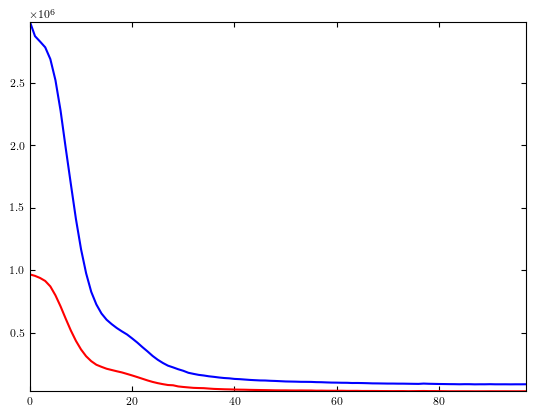

In [36]:
plt.plot(all_train_loss,'b-')
plt.plot(all_valid_loss,'r-')

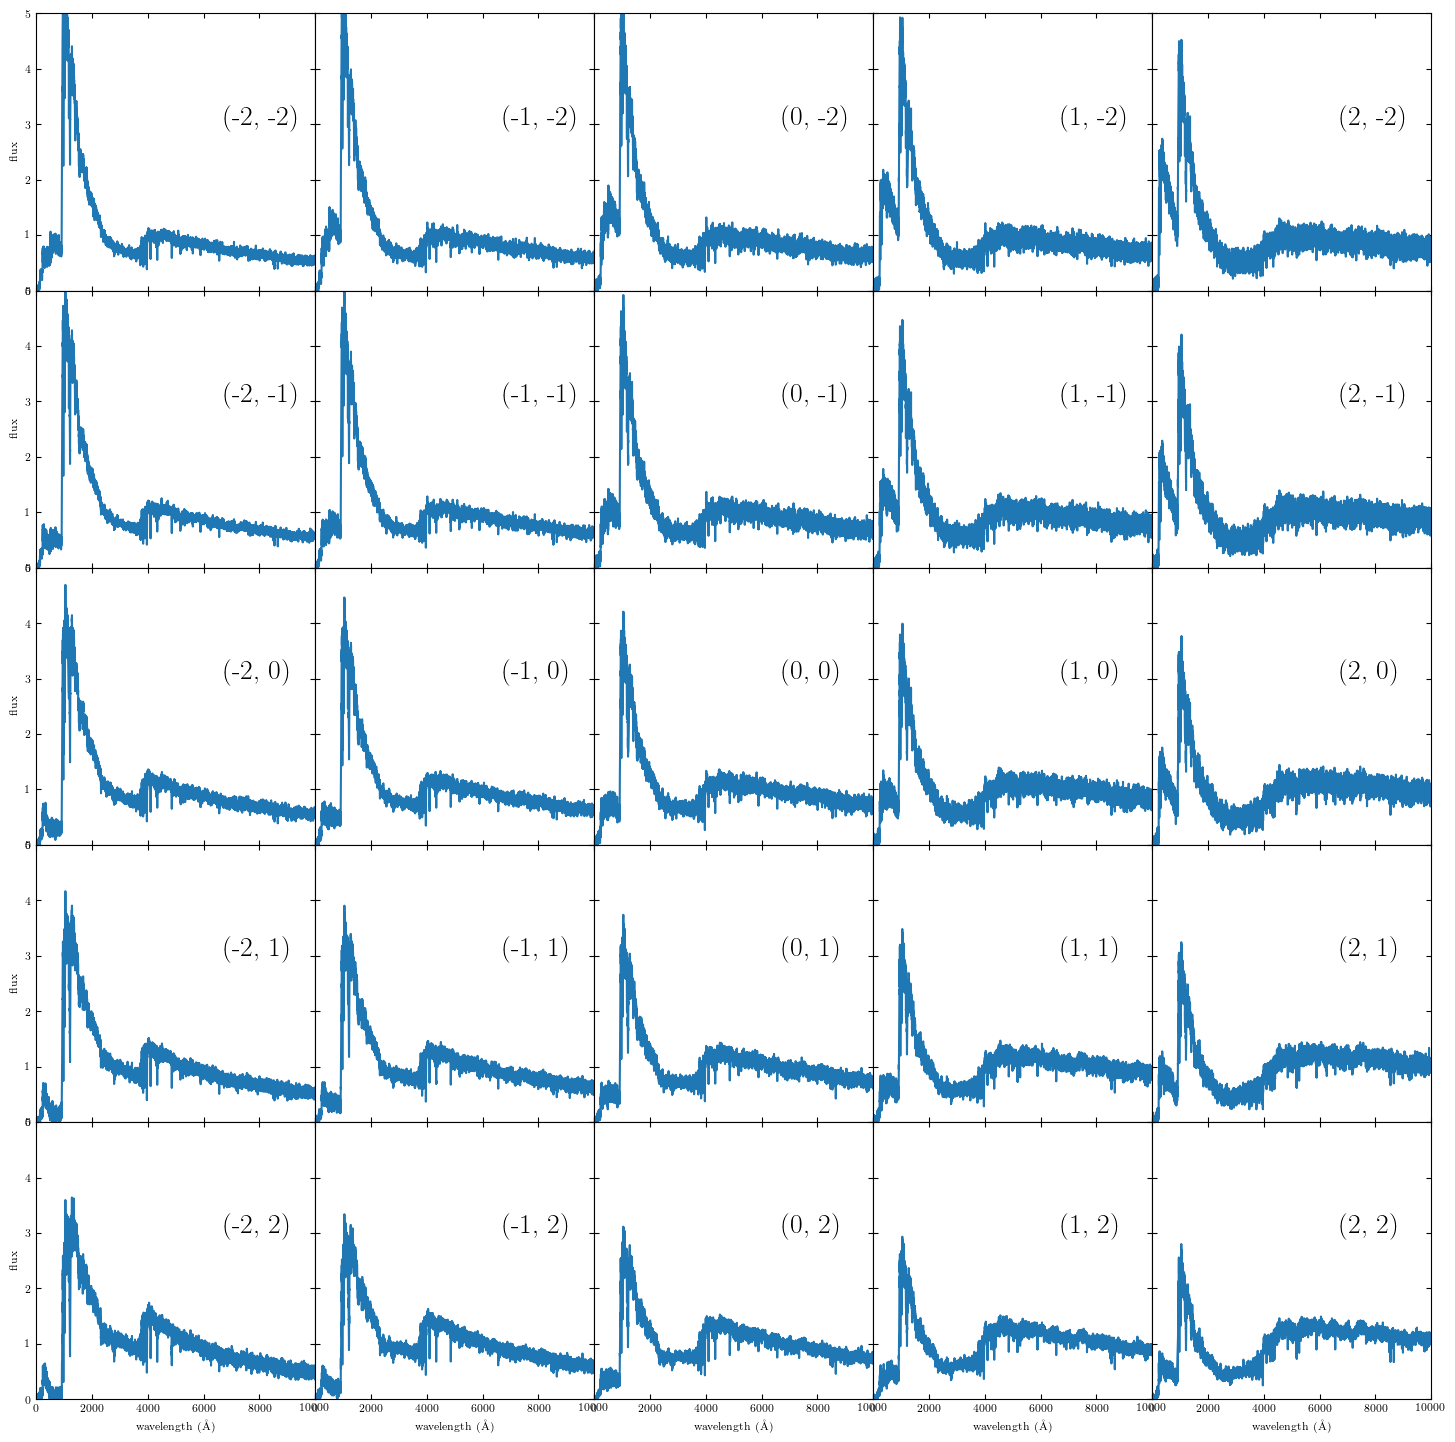

In [37]:
# plot results

with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-2.,-1,0.,1,2.]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            
            #idx_fig = (2-j)*len(parvalues)+i+1
            idx_fig = j*len(parvalues)+i +1
            
        
            ax = fig.add_subplot(5, 5, idx_fig)

            z = np.zeros((1,2), dtype=np.float32)
            z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            ax.plot(wavelengths, meanspectrum+spectrum.numpy()[0,:])
            ax.text(6750, 3, '(%i, %i)' % (z1,z2),fontsize=20)

            ax.set_xlim(0, 10000)
            ax.set_ylim(0, 5)

            if i == 0:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == 4:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.show()

# Explore latent space